In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./')
sys.path.append('../')

In [3]:
%matplotlib widget

import sys
import os
import h5py
from matplotlib import pyplot as plt
import zarr
import numpy as np
from copy import deepcopy
from segmentation import *
import waterz
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display
import h5py    


In [5]:
#file = 'anno_alice_T2030_tiny.zarr'
file = './data/anno_alice_T2035.zarr'
a = zarr.open(file, 'a')
print(a.tree(level=2))

/
 ├── Raw (4, 5, 15, 100, 100) float64
 └── gt_trackimage (5, 15, 100, 100) uint64


In [5]:
# Remove timesteps with corrupted data
#a['Raw'] = a['Raw'][:,5:]
#a['gt_trackimage'] = a['gt_trackimage'][5:]

In [4]:
from scipy.spatial import distance

def mask(img, label):
    mask = np.zeros((img.shape), dtype='uint64')
    mask[img == label] = 1
    return mask

def dice_coefficient(y_true, y_pred):
    return 1 - distance.dice(y_true.flatten(), y_pred.flatten())

def jaccard_coefficient(y_true, y_pred):
    return 1 - distance.jaccard(y_true.flatten(), y_pred.flatten())

# Track 2 Frames

## Visualize pairs

## Unmatched pairs

# Track Multiple frames

## Generate tracks_data

In [ ]:
def encode_id(mask, t):
    region = regionprops(mask)
    z, y, x = region[0].centroid
    position = (t, int(z), int(y), int(x))
    id = encode64((t, int(z), int(y), int(x), int(region[0].area)),bits=[9,12,12,12,19])

    return id

tracks_data = []
pairs3 = deepcopy(pairs2)
for t, _pairs in enumerate(pairs3):
    print('t:',t)
    for cell_t1 in _pairs.keys():
        cell_t0 = _pairs[cell_t1]
        print('(%s, %s)' % (cell_t0, cell_t1))

        mask_t0 = masks2[t][cell_t0]
        mask_t1 = masks2[t+1][cell_t1]
        r_t0 = regionprops(mask_t0)
        r_t1 = regionprops(mask_t1)

        try:
            z_0, y_0, x_0 = r_t0[0].centroid
            z_1, y_1, x_1 =  r_t1[0].centroid
        except:
            continue

        id = encode_id(mask_t0)
        if t>0:
            id = pairs3[t-1].get(cell_t0, id)               
            tracks_data.append([id, t+1, int(z_1), int(y_1), int(x_1)])
        else:
            tracks_data.append([id, t, int(z_0), int(y_0), int(x_0)])
            tracks_data.append([id, t+1, int(z_1), int(y_1), int(x_1)])
        pairs3[t][cell_t1] = id
pairs3

# track cells

In [5]:
def encode_id(mask, t):
    region = regionprops(mask)
    z, y, x = region[0].centroid
    position = (t, int(z), int(y), int(x))
    id = encode64((t, int(z), int(y), int(x), int(region[0].area)),bits=[9,12,12,12,19])

    return id, position

def track2(boundaries, wz_t=0.6, track_t=0.05):
    max_t, *_ = boundaries.shape

    _cells_data = {}
    _cell_ids = {}
    _masks = {}
    _fragments = {}
    for t in range(max_t):
        print('t:', t)
        img = deepcopy(boundaries[t])
        fragments_t = get_fragments(img, wz_t)           # Segment boundaries into fragments
        
        _fragments[t] = fragments_t
        _masks[t] = []
        _cell_ids[t] = []

        # Iterate over all unique cell fragment ids
        for i in np.unique(fragments_t):
            mask_c = mask(fragments_t, i)      # Get call mask
            _masks[t].append(mask_c)
            
            id_c, pos = encode_id(mask_c, t)   # Get id and regionprops data
            vol = np.sum(mask_c)
            _cell_ids[t].append(id_c)          # Store relation between cell fragment number and cell id
            
            _cells_data[id_c] = {
                'fragment_i': i,
                'vol': vol,
                't': pos[0],
                'z': pos[1],
                'y': pos[2],
                'x': pos[3],
                'parent': None,
                'parent_i': None,
                'origin': id_c
            }
            print('-i: %s - %s' % (i,id_c))
            
        if t>0:
            _masks_t0 = _masks[t-1]
            _masks_t1 = _masks[t]
            
            cells_t0, cells_t1 = len(_masks_t0), len(_masks_t1)
            _iou = np.zeros((cells_t0, cells_t1))

            # Compute IoU for all cells between t-1 and t
            print('-Computing IoU')
            for i, m0 in enumerate(_masks_t0):
                print('%s / %s' % (i, len(_masks_t0)))
                for j, m1 in enumerate(_masks_t1):
                    _iou[i,j] = jaccard_coefficient(m0, m1)

            for i, j in enumerate(np.argmax(_iou, axis=1)):
                id_c0 = _cell_ids[t-1][i]
                id_c1 = _cell_ids[t][j]
                _cell_t0 = _cells_data[id_c0]
                _cell_t1 = _cells_data[id_c1]
                
                if not _cell_t1['origin']:
                    _cell_t1['origin'] = id_c1      # Start new origin

                # Debugging
                print(i,j, _iou[i,j], id_c0, id_c1)
                
                if _iou[i,j] < track_t:         # IoU is below threshold for matching
                    print('--iou too small')
                    continue

                if type(_cell_t1['parent_i']) == int:
                    _i = _cell_t1['parent_i']
                    print('- already matched: %s (%s) - %s (%s)'  % (_iou[i,j], i, _iou[_i,j], _i))

                    if _iou[i, j] < _iou[_i, j]:
                        print('-- not replacing')
                        continue
                
                origin = _cell_t0.get('origin')
                _cell_t1['origin'] = origin
                _cell_t1['parent'] = id_c0
                _cell_t1['parent_i'] = i

    # Give each id its own color
    for i, id in enumerate(_cells_data.keys()):
        _cells_data[id]['color'] = i
            
    return _cells_data, _fragments

In [8]:
boundaries = a['Raw'][3]
cells_data, fragments = track2(boundaries, track_t=0.01, wz_t=0.6)

t: 0
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 682 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 3273
merging until threshold 0.6
computing initial scores
merging until 0.6
min edge score 0.00328553
threshold exceeded
merged 467 edges
extracting segmentation
-i: 1 - 7740604811313664
-i: 2 - 69102312955577856
-i: 4 - 26775642175439872
-i: 5 - 1267118431535104
-i: 6 - 74626628736519680
-i: 7 - 34024000778669056
-i: 9 - 352316171485184
-i: 10 - 1126741726724096
-i: 11 - 141227123015680
-i: 12 - 73536145132097024
-i: 13 - 28182742197862912
-i: 14 - 352522334109696
-i: 15 - 14637437546398720
-i: 17 - 246659986489344
-i: 18 - 119170121131362304
-i: 19 - 21674114399863808
-i: 20 - 114208849795220992
-i: 21 - 21779341117489152
-i: 27 - 1161874584371200
-i: 33 - 3730316575375360
-i: 36 - 880124736045056
-i: 38 - 1970771557613568
-i: 39 - 43030976749634048
-i: 42 

KeyboardInterrupt: 

## Convert cells_data to tracks_data

In [6]:
def gen_tracks(cells_data, fragments):
    _fragments = deepcopy(fragments)
    tracks_data = []
    for i in cells_data.keys():
        c = cells_data[i]
        origin, t, z, y, x, f_i = (c['origin'],c['t'],c['z'],c['y'],c['x'],c['fragment_i'])
        tracks_data.append([origin, t, z, y, x])
        print('t: %s, f_i: %s, i: %s, origin: %s' % (t, f_i, i, origin))
    
        # Change color
        fragments_t = _fragments[t]
        fragments_t[fragments_t == f_i] = origin
    
    # Change cell ids to fragment color
    __fragments = []
    colors_id = {}
    for t in _fragments.keys():
        print('t:',t)
        fragments_t = _fragments[t]
        ids = np.unique(fragments_t)
        
        for i in ids:
            color = cells_data[i]['color']
            print('- id: %s, color: %s:' % (i, color))
            fragments_t[fragments_t == i] = color
            colors_id[color] = i
        
        __fragments.append(fragments_t)

    return tracks_data, np.array(__fragments), colors_id

In [ ]:
tracks_data, fragments_colored, colors_id = gen_tracks(cells_data, fragments)

In [12]:
import napari
viewer = napari.Viewer()
viewer.add_image(a['Raw'][0], name='Raw')
viewer.add_image(a['Raw'][3], name='Boundaries')
viewer.add_labels(fragments_colored)
tracks = napari.layers.Tracks(tracks_data, 
                              name="track_test")
viewer.add_layer(tracks)
viewer.window.add_plugin_dock_widget(plugin_name="napari-arboretum", 
                                     widget_name="Arboretum")

(<napari._qt.widgets.qt_viewer_dock_widget.QtViewerDockWidget at 0x2fd4ba830>,
 <napari_arboretum.plugin.Arboretum at 0x2fd19caf0>)

In [7]:
def extract_labels(labels, raw, boundaries, fragments, tracks_data):
    _fragments = []
    _raw = []
    _boundaries = []
    _tracks_data = []
    for i, (r, b, f) in enumerate(zip(raw, boundaries, fragments)):
        _r = np.zeros(r.shape)
        _b = np.zeros(b.shape)
        _f = np.zeros(f.shape)
        
        for l in labels:
            m = mask(f, l)
            _r += m*r
            _b += m*b
            _f += m*l
            track_id = colors_id[l]
            for t in tracks_data:
                if t[0] == track_id:
                    _tracks_data.append(t)

        _raw.append(_r)
        _boundaries.append(_b)
        _fragments.append(_f)
        
        
    
    return np.array(_raw), np.array(_boundaries), np.array(_fragments, dtype='uint'), _tracks_data

In [11]:
show_labels = [65,131,60,99,92, 104, 113, 98, 553]
raw2, boundaries2, fragments2, tracks_data2 = extract_labels(show_labels, a['Raw'][0], a['Raw'][3], fragments_colored, tracks_data)

NameError: name 'fragments_colored' is not defined

In [10]:
import napari
viewer = napari.Viewer()
viewer.add_image(raw2, name='Raw')
viewer.add_image(boundaries2, name='Boundaries')
viewer.add_labels(fragments2)
tracks = napari.layers.Tracks(tracks_data2, 
                              name="track_test")
viewer.add_layer(tracks)

<Tracks layer 'track_test' at 0x2bf8e4d30>

Rendering frames...


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:04<00:00, 13.49it/s]


# Tracking on small-alice-tracked-loop

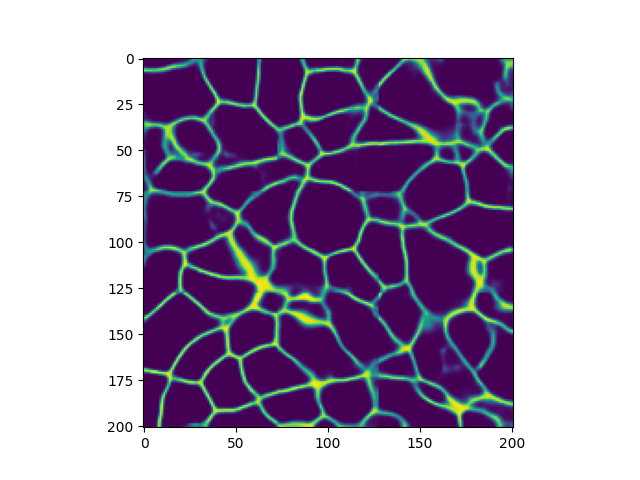

In [8]:
path="./data/fate-predict-datasets/Alice/small-alice-tracked-loop"
file=path+"/plantseg-predictions/C1C2_memZO1_TT_50_predictions.h5"
f1 = h5py.File(file,'r+')
img = f1['predictions'][0, 5]
f1.keys()
f1.close()

plt.figure()
plt.imshow(img)
plt.show()

In [9]:
from imaris_ims_file_reader.ims import ims
a = ims(path+'/AbiLoopMovie_tp1_50_ch_1_2.ims')

Opening readonly file: /Users/daniel/Spaces/Education/00.KU/Thesis/data/fate-predict-datasets/Alice/small-alice-tracked-loop/AbiLoopMovie_tp1_50_ch_1_2.ims 



In [10]:
raw = a[28:49, 0]
raw = np.flip(raw, axis=3)
raw = np.rot90(raw, axes=(2, 3))
raw.shape

(21, 44, 201, 201)

In [11]:
zo1 = a[28:49, 1]
zo1 = np.flip(zo1, axis=3)
zo1 = np.rot90(zo1, axes=(2, 3))
zo1.shape

(21, 44, 201, 201)

## Read last 20 frames

In [12]:
data = []
for i in range(30, 51):
    file="/plantseg-predictions/C1C2_memZO1_TT_"+str(i)+"_predictions.h5"
    print(file)
    f = h5py.File(path+"/"+file,'r+')
    data.append(f['predictions'][0])
data = np.array(data)

/plantseg-predictions/C1C2_memZO1_TT_30_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_31_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_32_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_33_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_34_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_35_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_36_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_37_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_38_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_39_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_40_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_41_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_42_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_43_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_44_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_45_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_46_predictions.h5
/plantseg-predictions/C1C2_memZO1_TT_47_predictions.h5
/plantseg-

In [13]:
data.shape

(21, 44, 201, 201)

## Track

In [69]:
#cells_data, fragments = track2(data, track_t=0.01, wz_t=0.1)

## Pickle cells_data

## Read Pickle

In [14]:
import pickle
with open(path+'/tracks_overseg_T30-50.pkl', 'rb') as f:
    d = pickle.load(f)
    cells_data = d['cells_data']
    fragments = d['fragments']

## Generate tracks

In [17]:
tracks_data, fragments_colored, colors_id = gen_tracks(cells_data, fragments)

t: 0, f_i: 1, i: 246531122790400, origin: 246531122790400
t: 0, f_i: 2, i: 1372714497475072, origin: 1372714497475072
t: 0, f_i: 3, i: 113470682337118208, origin: 113470682337118208
t: 0, f_i: 4, i: 345370990439569408, origin: 345370990439569408
t: 0, f_i: 5, i: 3801449785983488, origin: 3801449785983488
t: 0, f_i: 6, i: 9606939902214656, origin: 9606939902214656
t: 0, f_i: 7, i: 176119433134080, origin: 176119433134080
t: 0, f_i: 8, i: 1231916883771392, origin: 1231916883771392
t: 0, f_i: 9, i: 211595860901888, origin: 211595860901888
t: 0, f_i: 10, i: 2146762099785728, origin: 2146762099785728
t: 0, f_i: 11, i: 599085677988023808, origin: 599085677988023808
t: 0, f_i: 12, i: 246445238124544, origin: 246445238124544
t: 0, f_i: 13, i: 633499096711168, origin: 633499096711168
t: 0, f_i: 14, i: 335448688279162368, origin: 335448688279162368
t: 0, f_i: 15, i: 457405443866624, origin: 457405443866624
t: 0, f_i: 16, i: 36838630311855616, origin: 36838630311855616
t: 0, f_i: 17, i: 485369177

## Save tracks to h5

In [19]:
file=path+"/plantseg-predictions/C1C2_memZ01_tracked_predictions.h5"
f = h5py.File(file,'w')
f.create_dataset('cell_membrane', data=raw)
f.create_dataset('zo1', data=zo1)
f.create_dataset('plantseg', data=data)
f.create_dataset('tracked_fragments', data=fragments_colored)
f.close()

In [22]:
f = h5py.File(file,'r+')
f.keys()

<KeysViewHDF5 ['cell_membrane', 'plantseg', 'tracked_fragments', 'zo1']>

## Visualize

In [38]:
import napari
viewer = napari.Viewer()
viewer.add_image(data, name='PlantSeg')
viewer.add_image(raw, name='Cell Membrane')
viewer.add_image(zo1, name='Lumen ZO1')
viewer.add_labels(fragments_colored)
tracks = napari.layers.Tracks(tracks_data, 
                              name="track_test")
viewer.add_layer(tracks)
viewer.window.add_plugin_dock_widget(plugin_name="napari-arboretum", 
                                     widget_name="Arboretum")

(<napari._qt.widgets.qt_viewer_dock_widget.QtViewerDockWidget at 0x350245000>,
 <napari_arboretum.plugin.Arboretum at 0x35deeeb00>)

## Visualize selected cells

In [44]:
show_labels = [54, 49]
raw2, boundaries2, fragments_colored2, tracks_data2 = extract_labels(show_labels, data, data, fragments_colored, tracks_data)

import napari
viewer = napari.Viewer()
viewer.add_image(data, name='Boundaries')
viewer.add_labels(fragments_colored2)
tracks = napari.layers.Tracks(tracks_data2, 
                              name="track_test")
viewer.add_layer(tracks)

<Tracks layer 'track_test' at 0x35c22dab0>

## Visualize XY slice through time

54: completely connected in slice z=15

49: missing connections in slice z=15, maybe fully connected in other slice? (Fully connected in slice 12)

In [43]:
xyt_fragments = fragments_colored2[:, 12, :, :]
xyt_boundaries = data[:, 12, :, :]

viewer = napari.Viewer()
viewer.add_image(xyt_boundaries, name='Boundaries')
viewer.add_labels(xyt_fragments)

<Labels layer 'xyt_fragments' at 0x2e5cad5a0>

# Measure performance of tracking

In [43]:
#Precision / Recall for tracking between 2 frames
# for each fragment in frame1:
#   get matching fragment ID on GT based on IoU
# for each fragment in frame2:
#   get matching fragment ID on GT based on IoU
# check if the id gotten from frame1 matches the id gotten from frame2

def precision_recall_track(gt, pred, threshold=0.95):
    max_t, *_ = pred.shape

    tp = 0
    fp = 0
    for t in range(max_t):
        print('t:', t)
        if t>0:
            t0 = t-1
            t1 = t

            # match pred & gt labels in t0
            t0_pred = pred[t0]
            t0_gt = gt[t0]
            
            t0_gt_labels = np.unique(t0_gt)
            t0_pred_labels = np.unique(t0_pred)
            
            t0_gt_masks = {}
            for l in t0_gt_labels:
                t0_gt_masks[l] = mask(t0_gt, l)

            t0_pred_masks = {}
            for l in t0_pred_labels:
                t0_pred_masks[l] = mask(t0_pred, l)

            count = len(t0_gt_labels)
            t0_label_connection = {}
            t0_ji = np.zeros((len(t0_pred_labels)))
            
            for i, p in enumerate(t0_pred_labels):                
                print('t0: %s / %s' % (i, count))
                
                # Iterate over unmatched gt labels
                for g in t0_gt_labels:
                    jaccard_ij = jaccard_coefficient(t0_gt_masks[g], t0_pred_masks[p]) # IoU
                    
                    if jaccard_ij>t0_ji[i] and jaccard_ij>threshold:
                        t0_ji[i] = jaccard_ij
                        t0_label_connection[p] = g
                        t0_gt_labels = np.delete(t0_gt_labels, np.where(t0_gt_labels == g)) # No need to iterate over this in the future
                        continue

            # Check if there is a connection
            t1_pred = pred[t1]
            t1_gt = gt[t1]
            for p in t0_label_connection.keys():
                g = t0_label_connection[p]
                
                m1 = mask(t1_pred, p)
                m2 = mask(t1_gt, g)
                if jaccard_coefficient(m1, m2)>threshold:
                    tp+=1
                else:
                    fp+=1

    return tp, fp

precision_recall_track(fragments_colored[0:2], fragments_colored[0:2])

t: 0
t: 1
t0: 0 / 177
t0: 1 / 177
t0: 2 / 177
t0: 3 / 177
t0: 4 / 177
t0: 5 / 177
t0: 6 / 177
t0: 7 / 177
t0: 8 / 177
t0: 9 / 177
t0: 10 / 177
t0: 11 / 177
t0: 12 / 177
t0: 13 / 177
t0: 14 / 177
t0: 15 / 177
t0: 16 / 177
t0: 17 / 177
t0: 18 / 177
t0: 19 / 177
t0: 20 / 177
t0: 21 / 177
t0: 22 / 177
t0: 23 / 177
t0: 24 / 177
t0: 25 / 177
t0: 26 / 177
t0: 27 / 177
t0: 28 / 177
t0: 29 / 177
t0: 30 / 177
t0: 31 / 177
t0: 32 / 177
t0: 33 / 177
t0: 34 / 177
t0: 35 / 177
t0: 36 / 177
t0: 37 / 177
t0: 38 / 177
t0: 39 / 177
t0: 40 / 177
t0: 41 / 177
t0: 42 / 177
t0: 43 / 177
t0: 44 / 177
t0: 45 / 177
t0: 46 / 177
t0: 47 / 177
t0: 48 / 177
t0: 49 / 177
t0: 50 / 177
t0: 51 / 177
t0: 52 / 177
t0: 53 / 177
t0: 54 / 177
t0: 55 / 177
t0: 56 / 177
t0: 57 / 177
t0: 58 / 177
t0: 59 / 177
t0: 60 / 177
t0: 61 / 177
t0: 62 / 177
t0: 63 / 177
t0: 64 / 177
t0: 65 / 177
t0: 66 / 177
t0: 67 / 177
t0: 68 / 177
t0: 69 / 177
t0: 70 / 177
t0: 71 / 177
t0: 72 / 177
t0: 73 / 177
t0: 74 / 177
t0: 75 / 177
t0: 76 / 177

(177, 0)

# Process sliced data set

In [7]:
for i in range(6, 7):
    print(i)

6


In [ ]:
for i in range(6, 7):
    path='./data/tracking'
    file=path+'/Alice_slice_%i.h5' % i
    print(file)
    f = h5py.File(file,'r+')
    print(f['data'].shape)
    cells_data, fragments = track2(f['data'][3], track_t=0.01, wz_t=0.4)
    tracks_data, fragments_colored, colors_id = gen_tracks(cells_data, fragments)
    try:
        f.create_dataset('tracked_fragments', data=fragments_colored)
    except:
        d = f['tracked_fragments']
        d[...] = fragments_colored
    f.close()
    
    with open(path+'/Alice_slice_%i_cells.pkl' % i, 'wb') as f:
        pickle.dump({
            'fragments': fragments,
            'cells_data': cells_data
        }, f)

/Users/daniel/Spaces/Education/00.KU/Thesis/data/tracking/Alice_slice_6.h5
(4, 10, 10, 100, 100)
t: 0
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 593 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2737
merging until threshold 0.4
computing initial scores
merging until 0.4
min edge score 0.0089767
threshold exceeded
merged 273 edges
extracting segmentation
-i: 1 - 70755291234304
-i: 2 - 528384058720256
-i: 3 - 1337727695978496
-i: 4 - 4187756322358272
-i: 5 - 4222579921387520
-i: 6 - 106059924504576
-i: 7 - 30434541996869120
-i: 8 - 207904678057346560
-i: 9 - 17205415655769600
-i: 11 - 18472199086146048
-i: 12 - 9113516885672960
-i: 14 - 1513623795007488
-i: 15 - 1267161391693824
-i: 16 - 2991264345620480
-i: 17 - 880408180817920
-i: 18 - 38879049015100928
-i: 19 - 880098943172608
-i: 20 - 12104085446590464
-i: 22 - 106042761413120
-i: 23 - 3695089230545408


In [13]:
i = 0
path='./data'
file=path+'/Alice_slice_%i.h5' % i
f = h5py.File(file,'r+')

import napari
viewer = napari.Viewer()
viewer.add_image(f['data'][0], name='Raw')
viewer.add_image(f['data'][3], name='PlantSeg')
viewer.add_labels(f['tracked_fragments'])

<Labels layer 'Labels' at 0x29a5f6da0>